<a href="https://colab.research.google.com/github/MoonJaeHoon/Dacon_Sloan-Digital-Sky-Survey_SDSS/blob/master/Tutorial_GELU_DO_0_4_RedLR_%EB%85%B8%EB%93%9C%EC%88%98%EB%B0%94%EA%BF%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit #for data splitting
np.random.seed(123) #ensure reproducibility
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns

plt.style.use('seaborn') # matplotlib 도 종류가 다양하기 때문에 seaborn 스타일로 지정한 거임.
sns.set(font_scale=1) # (기본으로) 폰트 크기 2.5로 지정 미리 해놓는거임, 2.5면 꽤 크게 나옴

#ignore warnings
import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline 


import numpy as np # linear algebra
import pandas as pd 

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from keras.layers import Input, Dense
from keras.models import Model



#train = pd.read_csv('drive/My Drive/데이콘_천체유형/train.csv', index_col=0)
train = pd.read_csv('drive/My Drive/데이콘_천체유형/이상치_최대한_적게_train.csv', index_col=None)
test = pd.read_csv('drive/My Drive/데이콘_천체유형/test.csv', index_col=0)
sample_submission = pd.read_csv('drive/My Drive/데이콘_천체유형/sample_submission.csv', index_col=0)

#######################################################################################################
## petroMag_g 이상치 하나 더 없애기
name = 'petroMag_g'
drop_index = np.argmax(np.array(train[name]))
train = train.drop(index=drop_index,axis=0)
######################################################################################################

print('csv 파일 (train, test, sample)을 불러왔습니다')
print('train shape : {0}'.format(train.shape))
print('test shape : {0}'.format(test.shape))
print('='*50)

train_type_num = train['type_num']
needscaling_train = train.drop(['type','fiberID','type_num'],axis=1)
needscaling_test = test.drop(['fiberID'], axis=1)

sc = StandardScaler()
sc.fit(needscaling_train)
scaled_train = pd.DataFrame(sc.transform(needscaling_train),
                      columns=needscaling_train.columns,
                      index = needscaling_train.index)

scaled_test = pd.DataFrame(sc.transform(needscaling_test),
                      columns=needscaling_test.columns,
                      index = needscaling_test.index)

scaled_train['type_num'] = train_type_num
train_x = scaled_train.drop(['type_num'],axis=1)
train_y = scaled_train['type_num']
test_x = scaled_test

Using TensorFlow backend.


csv 파일 (train, test, sample)을 불러왔습니다
train shape : (199898, 23)
test shape : (10009, 21)


## petroMag_g 의 maximum 값 하나는 없애도 됨. ( 합리적으로)


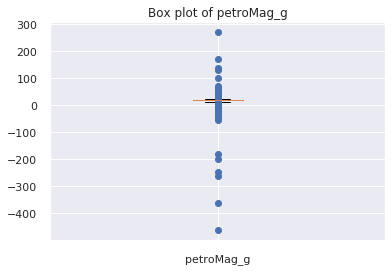

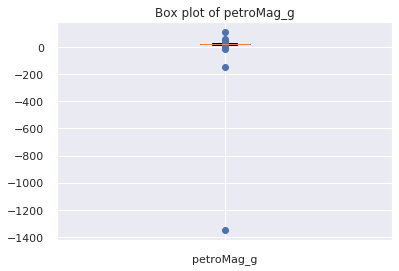

253.7626148220352
475.60843595216


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 6]
%matplotlib inline


# setting outlier symbol, title, xlabel
name = 'petroMag_g'
plt.boxplot(train[name], sym="bo")
plt.title('Box plot of {0}'.format(name))
plt.xticks([1], [name])
plt.show()


# setting outlier symbol, title, xlabel
name = 'petroMag_g'
plt.boxplot(test[name], sym="bo")
plt.title('Box plot of {0}'.format(name))
plt.xticks([1], [name])
plt.show()

Q1 = train.describe().loc['25%',name]
Q3 = train.describe().loc['75%',name]
minimum = train.describe().loc['min',name]
maximum = train.describe().loc['max',name]
IQR = Q3-Q1

print(maximum - Q3 + (1.5*IQR))
print(Q1 - (1.5*IQR) -  minimum)


## 딥러닝 모델 구축 시작 (Elu)

In [0]:
import numpy as np
import pandas as pd

#random seeds for stochastic parts of neural network 
np.random.seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

from keras.models import Sequential, Model, load_model
from keras.layers import  Activation,  Lambda, Flatten, LeakyReLU, ELU, Dense
from keras.layers import Input, Concatenate, Reshape, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam, SGD,RMSprop
from keras import  backend as K
from keras import metrics
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
#from swa.keras import SWA # swa optimizer - https://pypi.org/project/keras-swa/
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



################ Gelu #############

class Gelu(Activation):
    def __init__(self, activation, **kwargs):
        super(Gelu, self).__init__(activation, **kwargs)
        self.__name__='gelu'
        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Activation(gelu)})

################# tanh 활용 ( 범위 늘림 ) ##############
def custom_activation(x):
  return (K.tanh(x) * 145) + 155

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def create_nn_model():
    inp = Input(shape=(20,))
    x = Dense(2373)(inp)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.4)(x)
    
    x = Dense(2355)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.4)(x)

    x = Dense(1197)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.35)(x)

    x = Dense(1187)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.3)(x)

#    x = Dense(612)(x)
#    x = BatchNormalization()(x)
#    x = ELU()(x)
#    x = Activation(gelu)(x)
#    x = Dropout(rate = 0.3)(x)

    x = Dense(607)(x)
#    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(rate = 0.25)(x)


    out = Dense(19, activation='softmax')(x) #scalar_coupling_constant    
    model = Model(inputs=inp, outputs=out)
    return model

nn_model = create_nn_model(  )

In [0]:
csv_folder = '0219_이상치1_GELU_DO_0.4_layer수_배치크기조정'
rate = ''

import os
SAVEMODEL_NEWFOLDER0 = 'drive/My Drive/데이콘_천체유형/ModelCheck/' + csv_folder
SAVEMODEL_NEWFOLDER1 = 'drive/My Drive/데이콘_천체유형/기존모델저장/' + csv_folder
if not os.path.exists(SAVEMODEL_NEWFOLDER1):
  os.mkdir(SAVEMODEL_NEWFOLDER1)
  print('모델폴더를 새로 생성했습니다.')
SUBMISSION_NEWFOLDER = 'drive/My Drive/데이콘_천체유형/파일제출/' + csv_folder
if not os.path.exists(SUBMISSION_NEWFOLDER):
  os.mkdir(SUBMISSION_NEWFOLDER)
  print('제출폴더를 새로 생성했습니다.')

################## StratifiedShuffleSplit 를 이용해서 층화분할 #############
X_array = train_x.values
y_array = train_y.values

sss = StratifiedShuffleSplit(n_splits=2, test_size=1/13, random_state=123)
index1, index2 = sss.split(X_array, y_array)
train_index = index1[0].tolist()
val_index = index1[1].tolist()
train_input = X_array[train_index]
cv_input = X_array[val_index]
train_target  = y_array[train_index]
cv_target = y_array[val_index]



#train_index, val_index = train_test_split(np.arange(len(train_y)),random_state=42, test_size=1/13)
#train_input=train_x.iloc[train_index].values
#train_target0=train_y[train_index]
#train_target=train_target0.values
#cv_input=train_x.iloc[val_index].values
#cv_target0=train_y[val_index]
#cv_target = cv_target0.values


모델폴더를 새로 생성했습니다.
제출폴더를 새로 생성했습니다.


# Reduce LR on Plateau



> patience를 지정해놓고 metric(일반적으로 val_loss)를 보면서 줄어들지 않을 때에 (손실감소곡선이 너무 평탄할때) 일정상수를 initial_learning_rate에 곱해 local minima를 탈출하는 방법

# 스케쥴러



> 스케쥴러도 위의 Reduce LR과 굉장히 유사함. 하지만 스케쥴러는 위와 달리  (Linear, Cosine) 등 여러가지 종류의 스케쥴러로 **patience를 지정해서 쓰는게 아니라** 일정 패턴을 따라 큰 값에서 작은 값을 왔다갔다하며 그 사이에서 학습되도록 함.





## initial_rate = 1e-4 (과적합 심함)

### 1. lr 줄여서 local minima 문제 없앤듯
### 2. Drop Out 비율 더 높게 해주고
### 배치크기 256*6으로 올림

### 3. Gradient Exploding 문제 해결을 하고 싶다면... clip value 지정해줘야 할 듯 (얘는 아직 적용 안해봄)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 184521 samples, validate on 15377 samples
Epoch 1/800





184521/184521 [==============================] - 18s 96us/step - loss: 0.8977 - sparse_categorical_crossentropy: 0.8977 - val_loss: 0.5915 - val_sparse_categorical_crossentropy: 0.5915
Epoch 2/800
184521/184521 [==============================] - 6s 35us/step - loss: 0.5966 - sparse_categorical_crossentropy: 0.5966 - val_loss: 0.5356 - val_sparse_categorical_crossentropy: 0.5356
Epoch 3/800
184521/184521 [==============================] - 6s 35us/step - loss: 0.5453 - sparse_categorical_crossentropy: 0.5453 - val_loss: 0.5534 - val_sparse_categorical_crossentropy: 0.5534
Epoch 4/800
184521/184521 [==============================] - 6s 35us/step - loss: 0.5180 - sparse_categorical_crossentropy: 0.5180 - val_loss: 0.4909 - val_sparse_categorical_crossentropy: 0.4909
Epoch 5/800
184521/184521 [==============================] -

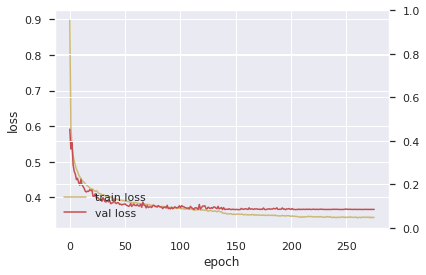

기존nn모델의 train loss를 출력합니다
train, loss and metric: [0.3196354617643328, 0.3196354617643328]
기존nn모델의 valid loss를 출력합니다
valid, loss and metric: [0.3648399589329506, 0.3648399589329506]


In [0]:
epoch =  800
pat =  80
red_pat =  25
batchsize = 256*6
initial_rate = 1e-4
factor = 1/np.sqrt(10) # red_patience 만큼 기다리다가, 학습률을 *factor 배로 줄여버림 
minimumlr = 1e-7
min_delta = 1e-6

import os
MODEL_SAVE_FOLDER_PATH0 = SAVEMODEL_NEWFOLDER0 +  '/initial_rate=%s/' % initial_rate ## checkpoint
MODEL_SAVE_FOLDER_PATH1 = SAVEMODEL_NEWFOLDER1 +  '/initial_rate=%s/' % initial_rate ## 기존모델저장
if not os.path.exists(MODEL_SAVE_FOLDER_PATH1):
  os.mkdir(MODEL_SAVE_FOLDER_PATH1)
check_path = MODEL_SAVE_FOLDER_PATH0 + '{epoch:02d}-{val_loss:.4f}.hdf5'
json_path = MODEL_SAVE_FOLDER_PATH1 + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH1 +"model1.h5"

### model early stopping : 더이상 성능 개선이 되지 않으면 멈춤
es = EarlyStopping(monitor= 'val_loss', patience = pat, verbose = 1, mode='min',
                    restore_best_weights = True
                   #,min_delta = 1e-6
                   ) 

### model check point
mc = ModelCheckpoint(filepath=check_path, monitor='val_loss', mode='min', save_best_only=True)

## ReduceLR on Plateau : val_loss가 안 줄어들 때 lr을 작게 할 수 있음 (local minima 대처방법)
rlr = ReduceLROnPlateau(monitor='val_loss', factor = factor,   # patience 만큼 기다리다가 0.1이면 학습률을 0.1배로 줄여버림 
                        patience = red_pat, mode = 'min', verbose = 1,
                        min_lr = minimumlr
                        )

from keras import optimizers
optimizer = optimizers.Adam(
    lr=initial_rate,
)

## compile model
CCE = metrics.sparse_categorical_crossentropy

nn_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              #metrics=['accuracy']
              #metrics=[metrics.sparse_categorical_accuracy]
              metrics=[CCE]
              )
## fitting model
hist = nn_model.fit(  train_input, train_target,validation_data=[cv_input, cv_target],
                    batch_size=batchsize,
                    epochs=epoch,
                    callbacks = [es 
                                 #,mc
                                 ,rlr
                                ] )

## save model
model_json = nn_model.to_json()
with open(json_path, "w") as json_file : 
    json_file.write(model_json)
## model weight save
nn_model.save_weights(weight_path)
print("모델저장완료")
print("="*50)

print("Loss와 ACC에 대한 Plot을 그립니다")

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')

#acc_ax.plot(hist.history['acc'], 'b', label='train acc')
#acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
#acc_ax.set_ylabel('accuracy')
#acc_ax.legend(loc='upper left')
plt.show()

## evaluate model
print('기존nn모델의 train loss를 출력합니다')
loss_and_metric = nn_model.evaluate(train_input, train_target, batch_size=batchsize, verbose=0)
print("train, loss and metric: {}".format(loss_and_metric))
## evaluate model
print('기존nn모델의 valid loss를 출력합니다')
loss_and_metric = nn_model.evaluate(cv_input, cv_target, batch_size=batchsize, verbose=0)
print("valid, loss and metric: {}".format(loss_and_metric))
## model weight save ## 기존 모델의 가중치 저장
#nn_model.save_weights(weight_path)

In [0]:
savingpath_csv = 'drive/My Drive/데이콘_천체유형/파일제출/' + csv_folder + '/이상치1_layer수_배치크기_조정_initial_rate_%s.csv' % initial_rate

print('best_n_epoch는 다음과 같습니다')
print(np.argmin(hist.history['val_loss']))
print('='*50)
print('final rate는 다음과 같습니다')
print(hist.history['lr'][np.argmin(hist.history['val_loss'])])
print('='*25)
y_pred = nn_model.predict(test_x)
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv(savingpath_csv, index=True)
print('csv 저장완료')

print('='*50)
best_val_loss = np.min(hist.history['val_loss'])
print("best_valid_loss: {}".format(best_val_loss))


best_n_epoch는 다음과 같습니다
195
final rate는 다음과 같습니다
3.1622774e-05
csv 저장완료
best_valid_loss: 0.3648399589329506


# 저장된 모델 로드해오기

In [0]:
initial_rate = 1e-4
SAVEMODEL_NEWFOLDER1 = 'drive/My Drive/데이콘_천체유형/기존모델저장/' + csv_folder
MODEL_SAVE_FOLDER_PATH1 = SAVEMODEL_NEWFOLDER1 +  '/initial_rate=%s/' % initial_rate ## 기존모델저장

## model load
json_path = MODEL_SAVE_FOLDER_PATH1 + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH1 +"model1.h5"

from keras.models import model_from_json
json_file = open(json_path, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
## model weight load
loaded_model.load_weights(weight_path)

## model load and evaluation
from keras import optimizers
final_rate = hist.history['lr'][np.argmin(hist.history['val_loss'])]
print("Loaded model from disk")
load_optimizer = optimizers.Adam(
    lr=final_rate,
)
CCE = metrics.sparse_categorical_crossentropy
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=load_optimizer
                     ,metrics=[CCE]
                     )
batchsize=1024
train_score = loaded_model.evaluate(train_input,train_target,verbose=0, batch_size=batchsize)
print('Load한 Check모델의 train loss를 출력합니다')
print("train, loss and metric: {}".format(train_score))
cv_score = loaded_model.evaluate(cv_input,cv_target,verbose=0, batch_size=batchsize)
print('Load한 Check모델의 val loss를 출력합니다')
print("valid, loss and metric: {}".format(cv_score))

Loaded model from disk
Load한 Check모델의 train loss를 출력합니다
train, loss and metric: [0.3077159990481829, 0.3077159990481829]
Load한 Check모델의 val loss를 출력합니다
valid, loss and metric: [0.3495782041837298, 0.3495782041837298]


In [0]:
csv_folder = ''
SAVEMODEL_NEWFOLDER1 = 'drive/My Drive/데이콘_천체유형/기존모델저장/' + csv_folder
initial_rate = 0.01
MODEL_SAVE_FOLDER_PATH1 = SAVEMODEL_NEWFOLDER1 +  '/initial_rate=%s/' % initial_rate ## 기존모델저장

## model load
json_path = MODEL_SAVE_FOLDER_PATH1 + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH1 +"model1.h5"

from keras.models import model_from_json
json_file = open(json_path, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
## model weight load
loaded_model.load_weights(weight_path)

## model load and evaluation
from keras import optimizers
#final_rate = hist.history['lr'][np.argmin(hist.history['val_loss'])]
print("Loaded model from disk")
load_optimizer = optimizers.Adam(
    #lr=final_rate
    lr = 0.0003162278
)
CCE = metrics.sparse_categorical_crossentropy
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=load_optimizer
                     ,metrics=[CCE]
                     )

Loaded model from disk




In [0]:
t = 1
for layer in loaded_model.layers:
  print('='*25 + '{0}번째'.format(t) + '='*25)
  weights = layer.get_weights()
  print(  (np.array(weights) ).shape )
  t += 1

=========================1번째=========================
(0,)
=========================2번째=========================
(2,)
=========================3번째=========================
(4, 2373)
=========================4번째=========================
(0,)
=========================5번째=========================
(0,)
=========================6번째=========================
(2,)
=========================7번째=========================
(4, 2355)
=========================8번째=========================
(0,)
=========================9번째=========================
(0,)
=========================10번째=========================
(2,)
=========================11번째=========================
(4, 1197)
=========================12번째=========================
(0,)
=========================13번째=========================
(0,)
=========================14번째=========================
(2,)
=========================15번째=========================
(4, 1187)
=========================16번째=========================
(0,)
=========================17번째